In [73]:
# Import necessary libraries
from sklearn.model_selection import train_test_split, GroupKFold
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
from tqdm import tqdm
import shap
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from catboost import CatBoostRegressor, Pool
from optuna.integration import CatBoostPruningCallback
from optuna.pruners import SuccessiveHalvingPruner
import joblib
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lime

warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")

In [ ]:
%%capture
!pip install optuna-integration

In [ ]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def time_group_cv_splits(X, y, groups, dates, n_splits=4):
    """Time-aware CV split grouped by clients."""
    gkf = GroupKFold(n_splits=n_splits)
    for train_idx, val_idx in gkf.split(X, y, groups):
        yield train_idx, val_idx


In [2]:
# Load and prepare data
train = pd.read_csv('/kaggle/input/biat-eda-and-prepoc/train.csv', parse_dates=['BOOKING_DATE', 'AJOUTE_LE'])
test = pd.read_csv('/kaggle/input/biat-eda-and-prepoc/test.csv', parse_dates=['BOOKING_DATE', 'AJOUTE_LE'])

# Convert to datetime
for df in [train, test]:
    df['BOOKING_DATE'] = pd.to_datetime(df['BOOKING_DATE'])
    df['AJOUTE_LE'] = pd.to_datetime(df['AJOUTE_LE'])

# Combine data for feature engineering
full_data = pd.concat([train, test], ignore_index=True)
full_data = full_data.sort_values(['CLIENT_ID', 'BOOKING_DATE'])

# Create target variable
full_data['NEXT_BOOKING_DATE'] = full_data.groupby('CLIENT_ID')['BOOKING_DATE'].shift(-1)
full_data['DAYS_TO_NEXT'] = (full_data['NEXT_BOOKING_DATE'] - full_data['BOOKING_DATE']).dt.days

In [3]:
# Enhanced feature engineering function
def feature_engineering(df):
    # Date features
    df['YEAR'] = df['BOOKING_DATE'].dt.year
    df['MONTH'] = df['BOOKING_DATE'].dt.month
    df['DAY'] = df['BOOKING_DATE'].dt.day
    df['DAY_OF_WEEK'] = df['BOOKING_DATE'].dt.dayofweek
    df['WEEK_OF_YEAR'] = df['BOOKING_DATE'].dt.isocalendar().week
    df['IS_MONTH_START'] = df['BOOKING_DATE'].dt.is_month_start.astype(int)
    df['IS_MONTH_END'] = df['BOOKING_DATE'].dt.is_month_end.astype(int)
    df['QUARTER'] = df['BOOKING_DATE'].dt.quarter
    
    # Time-based features
    df['DAYS_SINCE_ACCT_CREATION'] = (df['BOOKING_DATE'] - df['AJOUTE_LE']).dt.days
    df['DAYS_SINCE_LAST_TX'] = df.groupby('CLIENT_ID')['BOOKING_DATE'].diff().dt.days
    
    # Amount features
    df['AMOUNT_RATIO'] = df['AMOUNT_FCY'] / df['AMOUNT_LCY']
    df['EXCHANGE_DIFF'] = df['EXCHANGE_RATE'] - df['COURS_MARCHE']
    df['AMOUNT_SIGN'] = np.where(df['SENS'] == 'A', 1, -1)
    df['AMOUNT_SIZE'] = np.log1p(np.abs(df['AMOUNT_LCY']))
    df['AMOUNT_LCY_LOG'] = np.log1p(df['AMOUNT_LCY'])
    
    # Client aggregation features
    client_agg = df.groupby('CLIENT_ID').agg({
        'AMOUNT_LCY': ['mean', 'std', 'sum', 'min', 'max', 'count'],
        'DAYS_SINCE_LAST_TX': ['mean', 'std', 'median'],
        'BOOKING_DATE': ['min', 'max', 'count'],
        'DAYS_TO_NEXT': ['mean', 'median', 'std'] if 'DAYS_TO_NEXT' in df.columns else pd.NamedAgg(column='BOOKING_DATE', aggfunc='count')
    }).reset_index()
    
    client_agg.columns = ['CLIENT_' + '_'.join(col).strip('_') for col in client_agg.columns.values]
    client_agg = client_agg.rename(columns={'CLIENT_CLIENT_ID': 'CLIENT_ID'})
    
    df = pd.merge(df, client_agg, on='CLIENT_ID', how='left')
    
    # Group aggregation features
    group_agg = df.groupby('NOM_GROUPE').agg({
        'AMOUNT_LCY': ['mean', 'median', 'std'],
        'DAYS_TO_NEXT': ['mean', 'median', 'std'] if 'DAYS_TO_NEXT' in df.columns else pd.NamedAgg(column='BOOKING_DATE', aggfunc='count')
    }).reset_index()
    
    group_agg.columns = ['GROUP_' + '_'.join(col).strip('_') for col in group_agg.columns.values]
    group_agg = group_agg.rename(columns={'GROUP_NOM_GROUPE': 'NOM_GROUPE'})
    
    df = pd.merge(df, group_agg, on='NOM_GROUPE', how='left')
    
    # Segment aggregation features
    segment_agg = df.groupby('SEGMENTS').agg({
        'DAYS_TO_NEXT': ['mean', 'median', 'std'] if 'DAYS_TO_NEXT' in df.columns else pd.NamedAgg(column='BOOKING_DATE', aggfunc='count')
    }).reset_index()
    
    segment_agg.columns = ['SEGMENT_' + '_'.join(col).strip('_') for col in segment_agg.columns.values]
    segment_agg = segment_agg.rename(columns={'SEGMENT_SEGMENTS': 'SEGMENTS'})
    
    df = pd.merge(df, segment_agg, on='SEGMENTS', how='left')
    
    # Transaction sequence features
    df['TX_NUM'] = df.groupby('CLIENT_ID').cumcount() + 1
    df['TX_REVERSE_NUM'] = df.groupby('CLIENT_ID')['BOOKING_DATE'].rank(ascending=False, method='first')
    
    return df

# Apply feature engineering
full_data = feature_engineering(full_data)

In [4]:
# Encode categorical variables
def encode_categorical(df):
    # Low-cardinality features
    cat_cols = ['SENS', 'CURRENCY', 'NATURE_CLIENT', 'DIRECTION', 'SEGMENTS']
    
    for col in ['DESCRIPTION_OPERATION', 'NOM_GROUPE']:
        le = LabelEncoder()
        df[col + '_ENCODED'] = le.fit_transform(df[col].astype(str))
        cat_cols.append(col + '_ENCODED')
    
    return df, cat_cols

full_data, categorical_features = encode_categorical(full_data)

# Convert to category
CAT_COLS = ["SENS", "CURRENCY", "NATURE_CLIENT", "DIRECTION", "SEGMENTS",
            "DESCRIPTION_OPERATION_ENCODED", "NOM_GROUPE_ENCODED"]

for c in CAT_COLS:
    full_data[c] = full_data[c].astype("category")

In [5]:
# Split back to train and test
train = full_data[full_data['DAYS_TO_NEXT'].notnull()].copy()
test = full_data[full_data['DAYS_TO_NEXT'].isnull()].copy()

# Handle missing values
first_tx = train.groupby('CLIENT_ID')['BOOKING_DATE'].rank(method='first') == 1

train['DAYS_SINCE_LAST_TX'] = (
    train.groupby('CLIENT_ID')['DAYS_SINCE_LAST_TX']
      .transform(lambda s: s.fillna(s.median() if not pd.isna(s.median()) else 0))
)

train.loc[first_tx, 'DAYS_SINCE_LAST_TX'] = 0

# Fill other missing values
for col in train.columns:
    if train[col].isnull().sum() > 0 and train[col].dtype != 'category':
        if col.startswith('CLIENT_') or col.startswith('GROUP_') or col.startswith('SEGMENT_'):
            train[col] = train[col].fillna(train[col].median())
        else:
            train[col] = train[col].fillna(0)

# Do the same for test set
for col in test.columns:
    if test[col].isnull().sum() > 0 and test[col].dtype != 'category':
        if col.startswith('CLIENT_') or col.startswith('GROUP_') or col.startswith('SEGMENT_'):
            test[col] = test[col].fillna(test[col].median())
        else:
            test[col] = test[col].fillna(0)

In [6]:
# Re-cluster with k=2 on F-R-M features
client_freq_features = train.groupby('CLIENT_ID').agg({
    'BOOKING_DATE': 'count',  # Frequency
    'AMOUNT_LCY': 'mean',     # Monetary (use mean)
    'DAYS_SINCE_LAST_TX': 'mean'  # Recency
}).reset_index()

client_freq_features.columns = ['CLIENT_ID', 'TX_FREQUENCY', 'TX_AMOUNT_MEAN', 'TX_RECENCY']

# Log transform monetary value
client_freq_features['TX_AMOUNT_MEAN_LOG'] = np.log1p(np.abs(client_freq_features['TX_AMOUNT_MEAN']))

# Scale features for clustering
scaler = StandardScaler()
scaled_features = scaler.fit_transform(client_freq_features[['TX_FREQUENCY', 'TX_AMOUNT_MEAN_LOG', 'TX_RECENCY']])


In [9]:
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [10]:
# Apply K-means with k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
client_freq_features['CLUSTER'] = kmeans.fit_predict(scaled_features)

# Merge cluster labels back to train and test data
train = pd.merge(train, client_freq_features[['CLIENT_ID', 'CLUSTER']], on='CLIENT_ID', how='left')
test = pd.merge(test, client_freq_features[['CLIENT_ID', 'CLUSTER']], on='CLIENT_ID', how='left')

# For clients in test that weren't in train, assign to most frequent cluster
if test['CLUSTER'].isnull().sum() > 0:
    most_frequent_cluster = train['CLUSTER'].mode()[0]
    test['CLUSTER'] = test['CLUSTER'].fillna(most_frequent_cluster)


In [15]:
joblib.dump(kmeans, "kmeans.pkl")

['kmeans.pkl']

In [11]:
# Analyze the new clusters
cluster_summary = client_freq_features.groupby('CLUSTER').agg({
    'TX_FREQUENCY': ['mean', 'median', 'std'],
    'TX_AMOUNT_MEAN': ['mean', 'median'],
    'TX_RECENCY': ['mean', 'median'],
    'CLIENT_ID': 'count'
}).round(2)

print("New Cluster Summary (k=2):")
print(cluster_summary)

New Cluster Summary (k=2):
        TX_FREQUENCY                 TX_AMOUNT_MEAN          TX_RECENCY  \
                mean median      std           mean   median       mean   
CLUSTER                                                                   
0             400.20  101.0  1139.60      -11531.70  -350.28      11.67   
1               6.84    6.5     3.97       12860.87 -1344.23     112.61   

               CLIENT_ID  
        median     count  
CLUSTER                   
0         6.83       862  
1        96.51        70  


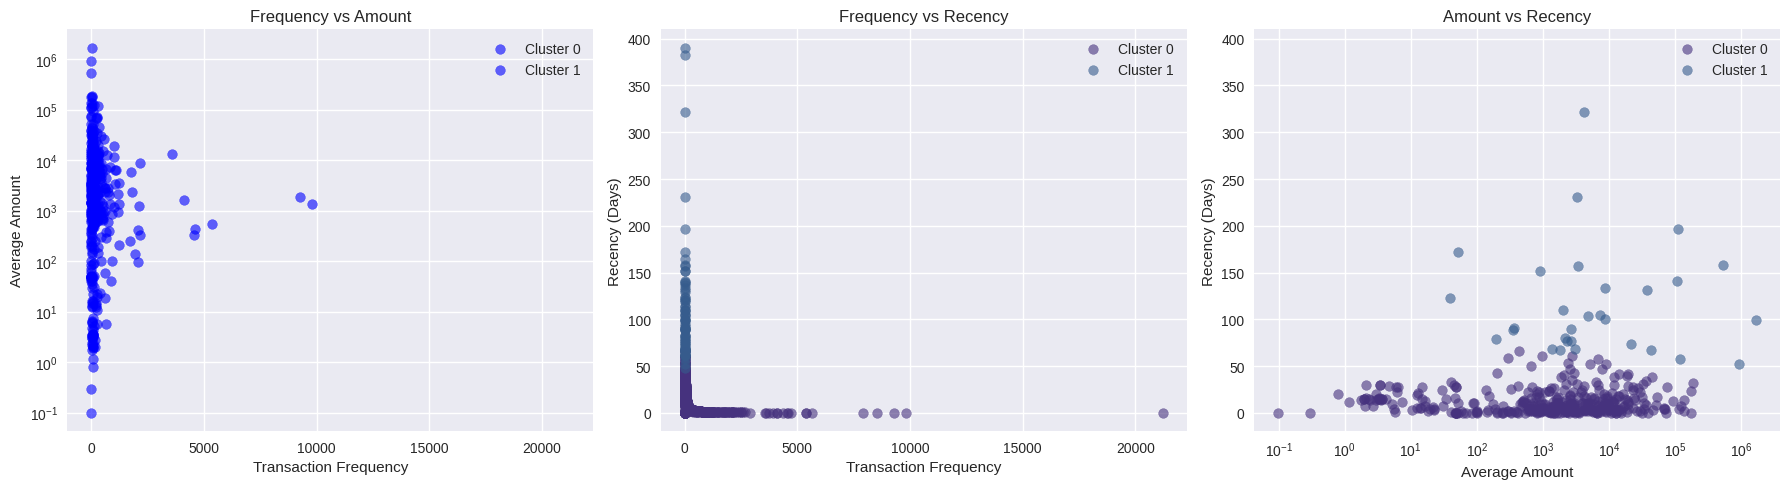

In [12]:
# Visualize the new clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Frequency vs Amount
for cluster in sorted(client_freq_features['CLUSTER'].unique()):
    cluster_data = client_freq_features[client_freq_features['CLUSTER'] == cluster]
    axes[0].scatter(cluster_data['TX_FREQUENCY'], cluster_data['TX_AMOUNT_MEAN'], 
                   alpha=0.6, label=f'Cluster {cluster}', color='blue')
axes[0].set_xlabel('Transaction Frequency')
axes[0].set_ylabel('Average Amount')
axes[0].set_title('Frequency vs Amount')
axes[0].legend()
axes[0].set_yscale('log')

# Frequency vs Recency
for cluster in sorted(client_freq_features['CLUSTER'].unique()):
    cluster_data = client_freq_features[client_freq_features['CLUSTER'] == cluster]
    axes[1].scatter(cluster_data['TX_FREQUENCY'], cluster_data['TX_RECENCY'], 
                   alpha=0.6, label=f'Cluster {cluster}')
axes[1].set_xlabel('Transaction Frequency')
axes[1].set_ylabel('Recency (Days)')
axes[1].set_title('Frequency vs Recency')
axes[1].legend()

# Amount vs Recency
for cluster in sorted(client_freq_features['CLUSTER'].unique()):
    cluster_data = client_freq_features[client_freq_features['CLUSTER'] == cluster]
    axes[2].scatter(cluster_data['TX_AMOUNT_MEAN'], cluster_data['TX_RECENCY'], 
                   alpha=0.6, label=f'Cluster {cluster}')
axes[2].set_xlabel('Average Amount')
axes[2].set_ylabel('Recency (Days)')
axes[2].set_title('Amount vs Recency')
axes[2].legend()
axes[2].set_xscale('log')

plt.tight_layout()
plt.show()

In [13]:
# Define features for modeling
keep_cols = [
    'DAYS_SINCE_LAST_TX', 'AMOUNT_LCY', 'AMOUNT_LCY_LOG',
    'EXCHANGE_DIFF', 'AMOUNT_RATIO', 'CLIENT_AMOUNT_LCY_mean', 
    'CLIENT_BOOKING_DATE_count', 'GROUP_AMOUNT_LCY_mean', 
    'DAYS_SINCE_ACCT_CREATION',
    'DESCRIPTION_OPERATION_ENCODED', 'NOM_GROUPE_ENCODED', 
    'DAY_OF_WEEK', 'WEEK_OF_YEAR', 'TX_NUM', 'TX_REVERSE_NUM',
    'QUARTER', 'CLIENT_DAYS_SINCE_LAST_TX_mean',
    'CLIENT_AMOUNT_LCY_std'
] + ['SENS', 'CURRENCY', 'NATURE_CLIENT', 'DIRECTION', 'SEGMENTS']


In [14]:
# Transform target to log1p
train['DAYS_TO_NEXT_LOG'] = np.log1p(train['DAYS_TO_NEXT'])

# Prepare data for each cluster
cluster_data = {}
for cluster_id in range(2):
    cluster_train = train[train['CLUSTER'] == cluster_id].copy()
    cluster_test = test[test['CLUSTER'] == cluster_id].copy()
    
    # Sort by booking date for time-aware splitting
    cluster_train = cluster_train.sort_values('BOOKING_DATE')
    
    X_train_cluster = cluster_train[keep_cols]
    y_train_cluster = cluster_train['DAYS_TO_NEXT_LOG']  # Use log target
    X_test_cluster = cluster_test[keep_cols]
    
    cluster_data[cluster_id] = {
        'X_train': X_train_cluster,
        'y_train': y_train_cluster,
        'X_test': X_test_cluster,
        'client_ids': cluster_train['CLIENT_ID'].values,
        'dates': cluster_train['BOOKING_DATE'].values,
        'test_idx': cluster_test.index
    }

In [19]:
# ==============================
# Cluster 0 → catboost+ fourier + Optuna
# ==============================
X0 = cluster_data[0]['X_train']
y0 = cluster_data[0]['y_train']
groups0 = cluster_data[0]['client_ids']
dates0 = cluster_data[0]['dates']
# ==============================
# Cluster 1 → ridge
# ==============================
X1 = cluster_data[1]['X_train']
y1 = cluster_data[1]['y_train']
groups1 = cluster_data[1]['client_ids']
dates1 = cluster_data[1]['dates']

In [27]:
# Copy to avoid touching cluster_data directly
X1_clean = X1.copy()

# --- Encode categorical features ---
for col in X1_clean.columns:
    if X1_clean[col].dtype.name == "category" or X1_clean[col].dtype == "object":
        le = LabelEncoder()
        X1_clean[col] = le.fit_transform(X1_clean[col].astype(str))

# --- Standardize numeric features ---
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X1_clean)

# --- Train/val split ---
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_scaled, y1, test_size=0.2, random_state=42)

# --- Ridge regression ---
model1 = Ridge(alpha=1.0, random_state=42)
model1.fit(X1_train, y1_train)
y1_pred = model1.predict(X1_val)

In [28]:
# --- Evaluation ---
rmse_val = np.sqrt(mean_squared_error(y1_val, y1_pred))
r2_val = r2_score(y1_val, y1_pred)

print("Cluster 1 Ridge RMSE:", rmse_val)
print("Cluster 1 Ridge R2:", r2_val)

Cluster 1 Ridge RMSE: 1.6807748198503094
Cluster 1 Ridge R2: 0.3238083636121747


In [70]:
joblib.dump(model1, "Ridge.pkl")

['Ridge.pkl']

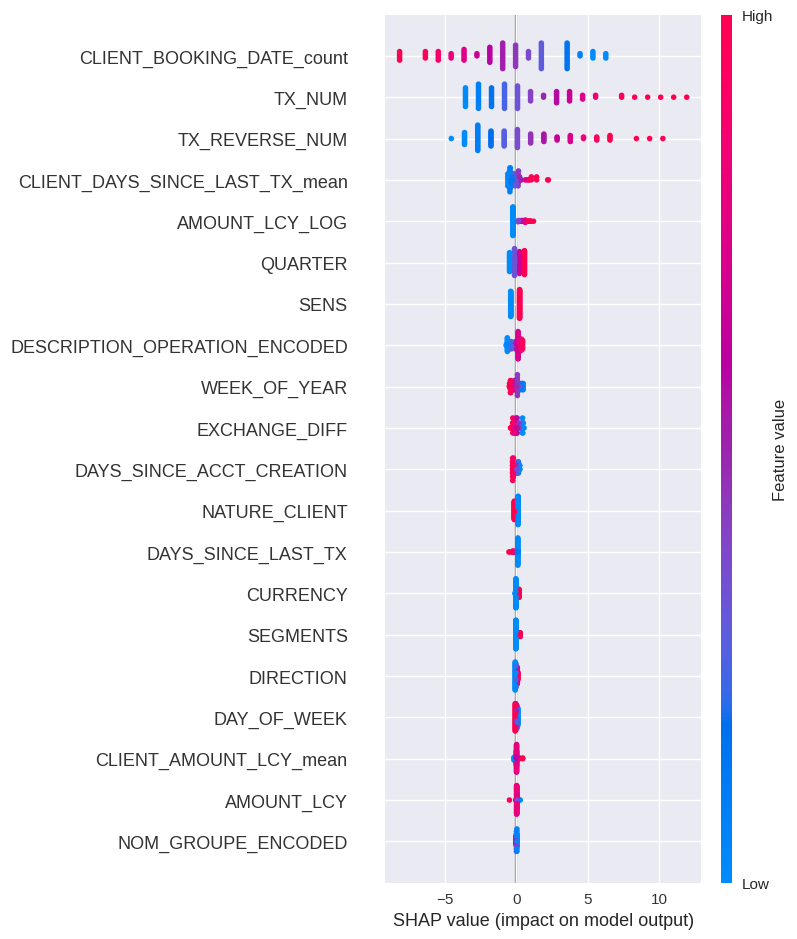

In [75]:
# =============================================
# SHAP & LIME for Ridge Model (Cluster 1)
# =============================================
# 1. SHAP Linear Explainer
shap_explainer_ridge = shap.LinearExplainer(model1, X1_train)
shap_values_ridge = shap_explainer_ridge.shap_values(X1_val)

# Generate summary plot
shap.summary_plot(shap_values_ridge, X1_val, feature_names=X1_clean.columns, show=False)

In [76]:
# 2. LIME Tabular Explainer
lime_explainer_ridge = lime.lime_tabular.LimeTabularExplainer(
    training_data=X1_train,
    feature_names=X1_clean.columns.tolist(),
    mode='regression',
    random_state=42
)

# Explain a specific instance
lime_exp_ridge = lime_explainer_ridge.explain_instance(
    X1_val[0], 
    model1.predict,
    num_features=10
)

# Show LIME explanation
lime_exp_ridge.show_in_notebook(show_all=False)

In [48]:
# ============================
# CatBoost + Fourier seasonality (Cluster 0)
# ============================

# ---------- 0) Fourier feature builder ----------
FOURIER_CONFIG = {
    "weekly":  {"period": 7.0,      "K": 3},
    "monthly": {"period": 30.4375,  "K": 2},
    "yearly":  {"period": 365.25,   "K": 3},
}

# use training start as reference so inference can replicate "t"
train_date_min = pd.to_datetime(dates0).min()

def _relative_days(dates, ref_date):
    """
    Returns float days relative to ref_date.
    Handles DatetimeIndex/Series, TimedeltaIndex/Series, arrays, strings.
    """
    s = pd.Series(dates)

    if pd.api.types.is_datetime64_any_dtype(s):
        delta = s - pd.Timestamp(ref_date)
    elif pd.api.types.is_timedelta64_dtype(s):
        delta = s
    else:
        s = pd.to_datetime(s, errors="coerce")
        delta = s - pd.Timestamp(ref_date)

    # convert to float days without using .dt on Index
    return (delta / pd.Timedelta(days=1)).to_numpy(dtype=float)
def make_fourier_df(dates, config, ref_date):
    t = _relative_days(dates, ref_date)
    feats = {}
    for name, cfg in config.items():
        P, K = cfg["period"], cfg["K"]
        for k in range(1, K + 1):
            feats[f"{name}_sin_{k}"] = np.sin(2.0 * np.pi * k * t / P)
            feats[f"{name}_cos_{k}"] = np.cos(2.0 * np.pi * k * t / P)
    return pd.DataFrame(feats, index=pd.RangeIndex(len(t)))


In [44]:
# ---------- 1) Build design matrix with seasonality ----------
# Fix dtypes (UInt32 can be annoying)
X0_fixed = X0.copy()
if "WEEK_OF_YEAR" in X0_fixed.columns and str(X0_fixed["WEEK_OF_YEAR"].dtype).lower().startswith("uint"):
    X0_fixed["WEEK_OF_YEAR"] = X0_fixed["WEEK_OF_YEAR"].astype("int32")

# Detect categorical columns on the full matrix BEFORE adding Fourier
cat_cols = [c for c in X0_fixed.columns if str(X0_fixed[c].dtype) == "category"]

# Add Fourier features
fourier_df = make_fourier_df(dates0, FOURIER_CONFIG, train_date_min)
X0_aug = pd.concat([X0_fixed.reset_index(drop=True), fourier_df.reset_index(drop=True)], axis=1)

# Category baseline mapping (so splits have aligned category sets)
base_cats = {c: X0_aug[c].cat.categories for c in cat_cols}

def align_cats(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for c in cat_cols:
        if str(df[c].dtype) != "category":
            df[c] = df[c].astype("category")
        df[c] = df[c].cat.set_categories(base_cats[c])
    return df

# CatBoost wants categorical indices
cat_idx = [X0_aug.columns.get_loc(c) for c in cat_cols]


In [45]:
# ---------- 2) Time-aware holdout (last 20%) ----------
order = np.argsort(pd.to_datetime(dates0))
X_sorted = X0_aug.iloc[order].reset_index(drop=True)
y_sorted = pd.Series(y0).iloc[order].reset_index(drop=True)   # log-target
groups_sorted = pd.Series(groups0).iloc[order].reset_index(drop=True)
dates_sorted = pd.to_datetime(pd.Series(dates0).iloc[order]).reset_index(drop=True)

split_idx = int(0.8 * len(X_sorted))
X_train = align_cats(X_sorted.iloc[:split_idx])
X_valid = align_cats(X_sorted.iloc[split_idx:])
y_train_log = y_sorted.iloc[:split_idx]
y_valid_log = y_sorted.iloc[split_idx:]
groups_train = groups_sorted.iloc[:split_idx]

train_pool = Pool(X_train, y_train_log, cat_features=cat_idx)
valid_pool = Pool(X_valid, y_valid_log, cat_features=cat_idx)


In [49]:
# pick a subset of clients for tuning (keeps leakage-safe grouping)
CLIENT_SUBFRAC = 0.25  # tune on ~25% of clients; bump to 0.4 if still fast
rng = np.random.RandomState(42)
unique_clients = groups_sorted.unique()
sub_clients = rng.choice(unique_clients, size=int(len(unique_clients)*CLIENT_SUBFRAC), replace=False)
mask_sub = groups_sorted.isin(sub_clients)

X_tune = align_cats(X_sorted[mask_sub])
y_tune = y_sorted[mask_sub]
groups_tune = groups_sorted[mask_sub]

# holdout for final report (use last 20% of full data, not just subset)
split_idx = int(0.8 * len(X_sorted))
X_hold = align_cats(X_sorted.iloc[split_idx:])
y_hold_log = y_sorted.iloc[split_idx:]
y_hold = np.expm1(y_hold_log.to_numpy())


In [50]:
# ---------- 2) Optuna setup: pruner + sampler ----------
sampler = optuna.samplers.TPESampler(
    n_startup_trials=8, multivariate=True, group=True, seed=42
)
pruner = SuccessiveHalvingPruner(min_resource=200, reduction_factor=3)  # kills losers early
study = optuna.create_study(direction="minimize", sampler=sampler, pruner=pruner)


[I 2025-08-22 02:55:06,362] A new study created in memory with name: no-name-80646c7f-8c77-496e-9d76-2595d46086ce


In [51]:
# ---------- 3) Objective: 2-fold GroupKFold on tuning subset ----------
def objective(trial: optuna.Trial):
    params = {
        "loss_function": "RMSE",
        "eval_metric": "RMSE",
        "random_state": 42,
        "allow_writing_files": False,
        # uncomment on Kaggle GPU:
        # "task_type": "GPU",
        # "devices": "0",
        # keep tuning cheap:
        "iterations": trial.suggest_int("iterations", 800, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.12, log=True),
        "depth": trial.suggest_int("depth", 6, 9),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 20.0, log=True),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 4.0),
        "random_strength": trial.suggest_float("random_strength", 0.0, 1.5),
        "border_count": trial.suggest_int("border_count", 64, 192),
        # column and row subsampling (faster + regularization)
        "rsm": trial.suggest_float("rsm", 0.7, 1.0),           # colsample
        "subsample": trial.suggest_float("subsample", 0.7, 1.0) # rows
    }

    gkf = GroupKFold(n_splits=2)
    maes = []

    for tr_idx, te_idx in gkf.split(X_tune, y_tune, groups=groups_tune):
        X_tr = align_cats(X_tune.iloc[tr_idx])
        X_te = align_cats(X_tune.iloc[te_idx])
        y_tr_log = y_tune.iloc[tr_idx]
        y_te_log = y_tune.iloc[te_idx]

        model = CatBoostRegressor(**params)

        pruning_cb = CatBoostPruningCallback(trial, "RMSE")
        model.fit(
            Pool(X_tr, y_tr_log, cat_features=cat_idx),
            eval_set=Pool(X_te, y_te_log, cat_features=cat_idx),
            use_best_model=True,
            early_stopping_rounds=150,
            verbose=False,
            callbacks=[pruning_cb]
        )

        # evaluate in REAL days
        preds = np.expm1(model.predict(X_te))
        y_te = np.expm1(y_te_log.to_numpy())
        maes.append(mean_absolute_error(y_te, preds))

    return float(np.mean(maes))


In [52]:
# Budget the search (either fewer trials or a hard timeout)
study.optimize(objective, n_trials=25, timeout=1800, show_progress_bar=True)

  0%|          | 0/25 [00:00<?, ?it/s]

[I 2025-08-22 02:55:48,048] Trial 0 finished with value: 2.2104946350814423 and parameters: {'iterations': 1249, 'learning_rate': 0.09477795989599032, 'depth': 8, 'l2_leaf_reg': 6.009974718380312, 'bagging_temperature': 0.6240745617697461, 'random_strength': 0.23399178050430397, 'border_count': 71, 'rsm': 0.9598528437324805, 'subsample': 0.8803345035229626}. Best is trial 0 with value: 2.2104946350814423.
[I 2025-08-22 02:59:09,167] Trial 1 finished with value: 2.279910298472944 and parameters: {'iterations': 1650, 'learning_rate': 0.0011035674808187713, 'depth': 9, 'l2_leaf_reg': 12.10689693600216, 'bagging_temperature': 0.8493564427131046, 'random_strength': 0.2727374508106509, 'border_count': 87, 'rsm': 0.7912726728878613, 'subsample': 0.8574269294896714}. Best is trial 0 with value: 2.2104946350814423.
[I 2025-08-22 03:00:50,334] Trial 2 finished with value: 2.245474205743222 and parameters: {'iterations': 1318, 'learning_rate': 0.004031978119147634, 'depth': 8, 'l2_leaf_reg': 1.51

In [53]:
print("\n===== Optuna (FAST) Best Params =====")
print(json.dumps(study.best_params, indent=2))
print(f"CV MAE (real days): {study.best_value:.4f}")



===== Optuna (FAST) Best Params =====
{
  "iterations": 1855,
  "learning_rate": 0.047959905058803834,
  "depth": 6,
  "l2_leaf_reg": 9.086606448211164,
  "bagging_temperature": 0.9980818561962933,
  "random_strength": 0.15388826775071196,
  "border_count": 150,
  "rsm": 0.9683075697058341,
  "subsample": 0.9896941004309929
}
CV MAE (real days): 2.2034


In [54]:
best_params

{'learning_rate': 0.003687076821356058,
 'num_leaves': 151,
 'max_depth': 12,
 'feature_fraction': 0.8294958941197903,
 'bagging_fraction': 0.8758590995393195,
 'bagging_freq': 4,
 'min_child_samples': 59}

In [55]:
# ---------- 4) Retrain BIG on full train split, eval on full holdout ----------
best_params = {
    "loss_function": "RMSE",
    "eval_metric": "RMSE",
    "random_state": 42,
    "allow_writing_files": False,
    "verbose": 200,
    # "task_type": "GPU",
    **study.best_params
}
# now allow more iterations to squeeze accuracy; still early-stop
best_params["iterations"] = max(best_params.get("iterations", 1500), 4000)


In [56]:
# full train split (first 80% by time)
X_full_train = align_cats(X_sorted.iloc[:split_idx])
y_full_train_log = y_sorted.iloc[:split_idx]

In [57]:
model_final = CatBoostRegressor(**best_params)
model_final.fit(
    Pool(X_full_train, y_full_train_log, cat_features=cat_idx),
    eval_set=Pool(X_hold, y_hold_log, cat_features=cat_idx),
    use_best_model=True,
    early_stopping_rounds=300
)

0:	learn: 0.8507493	test: 0.8104946	best: 0.8104946 (0)	total: 182ms	remaining: 12m 7s
200:	learn: 0.6655562	test: 0.6561258	best: 0.6560508 (191)	total: 29.5s	remaining: 9m 17s
400:	learn: 0.6550555	test: 0.6612123	best: 0.6552821 (225)	total: 58.9s	remaining: 8m 48s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.6552820962
bestIteration = 225

Shrink model to first 226 iterations.


In [58]:
pred_hold = np.expm1(model_final.predict(X_hold))
rmse = mean_squared_error(y_hold, pred_hold, squared=False)
mae  = mean_absolute_error(y_hold, pred_hold)
r2   = r2_score(y_hold, pred_hold)

print("\n===== Cluster 0 — CatBoost (FAST Optuna) on time holdout =====")
print(f"RMSE (real days): {rmse:.4f}")
print(f"MAE  (real days): {mae:.4f}")
print(f"R²   (real days): {r2:.4f}")


===== Cluster 0 — CatBoost (FAST Optuna) on time holdout =====
RMSE (real days): 5.4053
MAE  (real days): 1.6957
R²   (real days): 0.2442


In [59]:
joblib.dump(model_final, "CatBoost.pkl")

['CatBoost.pkl']

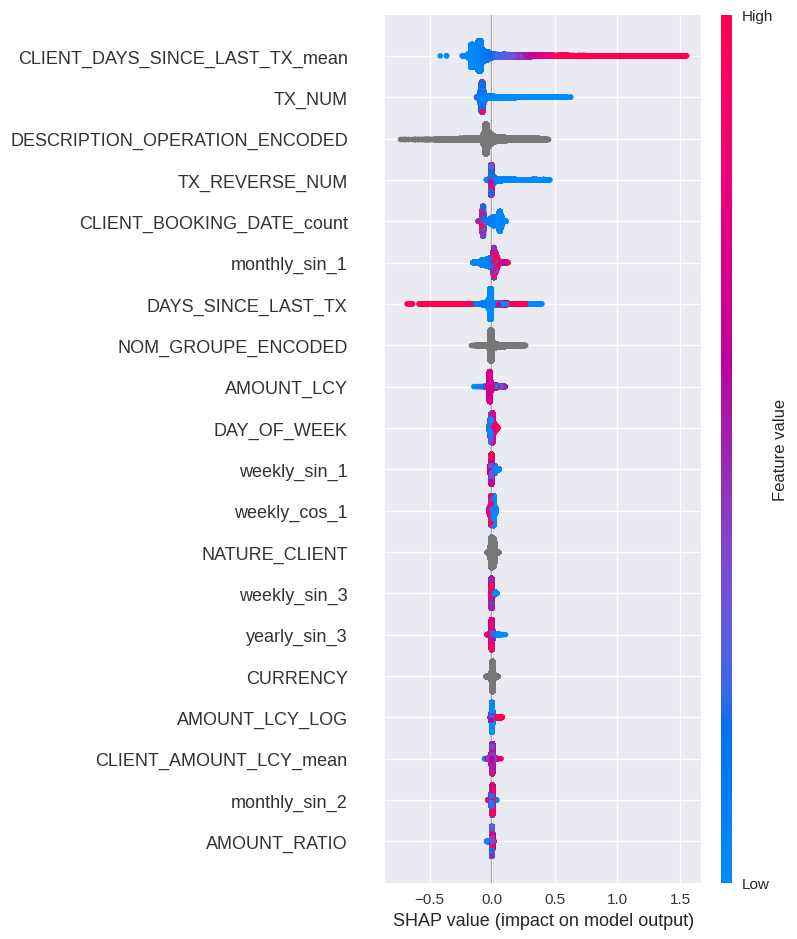

In [71]:
# =============================================
# SHAP & LIME for CatBoost Model (Cluster 0)
# =============================================
# Prepare explainer data (use validation set)
X0_val_explain = X_valid.copy()

# 1. SHAP Tree Explainer
shap_explainer_cb = shap.TreeExplainer(model_final)
shap_values_cb = shap_explainer_cb.shap_values(X0_val_explain)

# Generate summary plot
shap.summary_plot(shap_values_cb, X0_val_explain, show=False)